# Training Notebook

# RSNA 2023 Abdominal Trauma Detection with Pytorch + Lightning

This is just a fork from [KerasCV starter notebook [Train]](https://www.kaggle.com/code/aritrag/kerascv-starter-notebook-train), and corversion to Pytorch + Pytorch lightning.

# Setup and Imports

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import pytorch_lightning as pl

c:\Users\gabri\miniconda3\envs\ds_gpu\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [ ]:
from rsna_config import Config
from rsna_models import CT_2DModel
from rsna_data import CustomDataset, apply_augmentation
from rsna_utils import split_group, SimpleLogger
from rsna_visualization import plot_image_gallery, plot_per_task_accuracy, plot_accuracy, get_best_epoch

# Configuration

A particularly good practise is to have a configuration class for your notebooks. This not only keeps your configurations all at a single place but also becomes handy to map the configs to the performance of the model.

Please play around with the configurations and see how the performance of the model changes.

## Note on some observations

Reference Notebook: https://www.kaggle.com/code/aritrag/eda-train-csv

1. Class Dependencies: Refers to inherent relationships between classes in the analysis.
2. Complementarity: `bowel_injury` and `bowel_healthy`, as well as `extravasation_injury` and `extravasation_healthy`, are perfectly complementary, with their sum always equal to 1.0.
3. Simplification: For the model, only `{bowel/extravasation}_injury` will be included, and the corresponding healthy status can be calculated using a sigmoid function.
4. Softmax: `{kidney/liver/spleen}_{healthy/low/high}` classifications are softmaxed, ensuring their combined probabilities sum up to 1.0 for each organ, simplifying the model while preserving essential information.

In [2]:
class Config:
    SEED = 42
    IMAGE_SIZE = [256, 256]
    BATCH_SIZE = 32
    EPOCHS = 10
    TARGET_COLS  = [
        "bowel_healthy", "bowel_injury",
        "extravasation_healthy", "extravasation_injury",
        "kidney_healthy", "kidney_low", "kidney_high",
        "liver_healthy", "liver_low", "liver_high",
        "spleen_healthy", "spleen_low", "spleen_high",
        "any_injury"
    ]
    BACKBONE = "efficientnet_v2_s"

config = Config()

# Dataset

The dataset provided in the competition consists of DICOM images. We will not be training on the DICOM images, rather would work on PNG image which are extracted from the DICOM format.

[A helpful resource on the conversion of DICOM to PNG](https://www.kaggle.com/code/radek1/how-to-process-dicom-images-to-pngs)

In [3]:
BASE_PATH = f"data"
# BASE_PATH = f"/kaggle/input/rsna-atd-512x512-png-cropped"

## Meta Data

The `train.csv` file contains the following meta information:

- `patient_id`: A unique ID code for each patient.
- `series_id`: A unique ID code for each scan.
- `instance_number`: The image number within the scan. The lowest instance number for many series is above zero as the original scans were cropped to the abdomen.
- `[bowel/extravasation]_[healthy/injury]`: The two injury types with binary targets.
- `[kidney/liver/spleen]_[healthy/low/high]`: The three injury types with three target levels.
- `any_injury`: Whether the patient had any injury at all.


In [4]:
# train
dataframe = pd.read_csv(f"{BASE_PATH}/train.csv")
dataframe["image_path"] = f"{BASE_PATH}/train_images"\
                    + "/" + dataframe.patient_id.astype(str)\
                    + "/" + dataframe.series_id.astype(str)\
                    + "/" + dataframe.instance_number.astype(str) +".png"
dataframe = dataframe.drop_duplicates()

dataframe.head(2)

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,...,spleen_healthy,spleen_low,spleen_high,any_injury,series_id,instance_number,injury_name,image_path,width,height
0,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,362,Active_Extravasation,data/train_images/10004/21057/362.png,512,512
1,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,363,Active_Extravasation,data/train_images/10004/21057/363.png,512,512


We split the training dataset into train and validation. This is a common practise in the Machine Learning pipelines. We not only want to train our model, but also want to validate it's training.

A small catch here is that the training and validation data should have an aligned data distribution. Here we handle that by grouping the lables and then splitting the dataset. This ensures an aligned data distribution between the training and the validation splits.

In [5]:
# Function to handle the split for each group
def split_group(group, test_size=0.2):
    if len(group) == 1:
        return (group, pd.DataFrame()) if np.random.rand() < test_size else (pd.DataFrame(), group)
    else:
        return train_test_split(group, test_size=test_size, random_state=42)

# Initialize the train and validation datasets
train_data = pd.DataFrame()
val_data = pd.DataFrame()

# Iterate through the groups and split them, handling single-sample groups
for _, group in dataframe.groupby(config.TARGET_COLS):
    train_group, val_group = split_group(group)
    train_data = pd.concat([train_data, train_group], ignore_index=True)
    val_data = pd.concat([val_data, val_group], ignore_index=True)

In [6]:
train_data.shape, val_data.shape

((9612, 21), (2417, 21))

## Data Pipeline

In [7]:
class CustomRandomApply(torch.nn.Module):
    """Apply randomly a list of transformations with a given probability.

    .. note::
        In order to script the transformation, please use ``torch.nn.ModuleList`` as input instead of list/tuple of
        transforms as shown below:

        >>> transforms = transforms.RandomApply(torch.nn.ModuleList([
        >>>     transforms.ColorJitter(),
        >>> ]), p=0.3)
        >>> scripted_transforms = torch.jit.script(transforms)

        Make sure to use only scriptable transformations, i.e. that work with ``torch.Tensor``, does not require
        `lambda` functions or ``PIL.Image``.

    Args:
        transforms (sequence or torch.nn.Module): list of transformations
        p (float): probability
    """

    def __init__(self, transforms, p=0.5):
        super().__init__()
        self.transforms = transforms
        self.p = p

    def forward(self, img):
        for t in self.transforms:
            if self.p < torch.rand(1):
                img = t(img)
        return img

    def __repr__(self) -> str:
        format_string = self.__class__.__name__ + "("
        format_string += f"\n    p={self.p}"
        for t in self.transforms:
            format_string += "\n"
            format_string += f"    {t}"
        format_string += "\n)"
        return format_string

In [8]:
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

def decode_image_and_label(image_path, image_size=None):
    if image_size is None:
        image_size = config.IMAGE_SIZE
    image = Image.open(image_path).convert("RGB")
    image = image.resize(image_size, Image.BILINEAR)
    image = transforms.ToTensor()(image)
    return image

def apply_augmentation(images, labels):
    augmenter = CustomRandomApply(p=0.1,
                                  transforms=[
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.GaussianBlur(kernel_size=9, sigma=(0.1, 1)),
        transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
        transforms.RandomRotation(degrees=(0, 30)),
        transforms.ElasticTransform(alpha=50.0),
        transforms.RandomResizedCrop(size=(config.IMAGE_SIZE, config.IMAGE_SIZE),
                                     scale=(0.9, 0.99)),
        transforms.RandomPosterize(bits=8, p=0.7),
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5)
    ])
    
    augmented_images = torch.stack([augmenter(img) for img in images])
    return augmented_images, labels

class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, image_size = None):
        self.image_paths = image_paths
        self.labels = labels
        self.image_size = image_size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = decode_image_and_label(image_path, self.image_size)
        return image, label

In [9]:
paths  = train_data.image_path.tolist()
labels = train_data[config.TARGET_COLS].values

train_dataset = CustomDataset(image_paths=paths, labels=labels)
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
images, labels = next(iter(train_loader))
print("images.shape:", images.shape)
print("labels.shape:", labels.shape)

images.shape: torch.Size([32, 3, 256, 256])
labels.shape: torch.Size([32, 14])


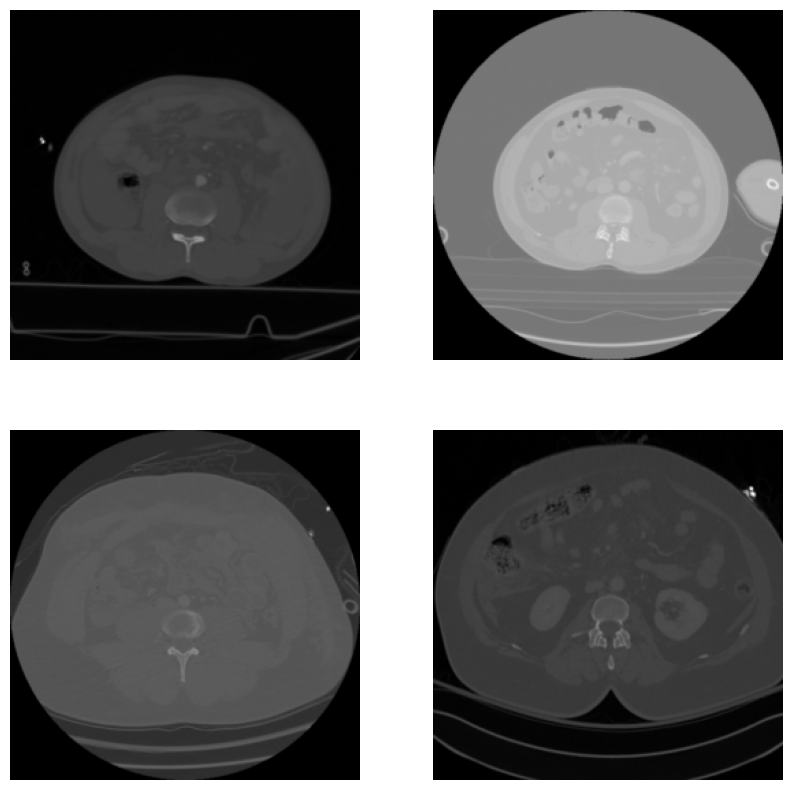

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_image_gallery(images, value_range=(0, 1), rows=2, cols=2):
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    for i in range(rows):
        for j in range(cols):
            idx = i * cols + j
            if idx < len(images):
                image = images[idx].numpy().transpose(1, 2, 0)
                image = np.clip(image, *value_range)
                axes[i, j].imshow(image)
                axes[i, j].axis('off')
    plt.show()

plot_image_gallery(images, value_range=(0, 1), rows=2, cols=2)

# Build Model

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision.transforms import Resize
import pytorch_lightning as pl

resnet_backbones = {
    "resnet18": {"model": models.resnet18, "weights": models.ResNet18_Weights.DEFAULT},
    "resnet34": {"model": models.resnet34, "weights": models.ResNet34_Weights.DEFAULT},
    "resnet50": {"model": models.resnet50, "weights": models.ResNet50_Weights.DEFAULT},
    "resnet101": {"model": models.resnet101, "weights": models.ResNet101_Weights.DEFAULT},
    "resnet152": {"model": models.resnet152, "weights": models.ResNet152_Weights.DEFAULT}
    }

efficientnet_backbones = {
    "efficientnet_v2_s": {"model": models.efficientnet_v2_s, "weights": models.EfficientNet_V2_S_Weights.DEFAULT},
    "efficientnet_v2_m": {"model": models.efficientnet_v2_m, "weights": models.EfficientNet_V2_M_Weights.DEFAULT},
    "efficientnet_v2_l": {"model": models.efficientnet_v2_l, "weights": models.EfficientNet_V2_L_Weights.DEFAULT}
    }

backbone_dict = {**resnet_backbones, **efficientnet_backbones}

tasks=["bowel", "extra", "liver", "kidney", "spleen", "any_injury"]

class CT_Model(pl.LightningModule):
    def __init__(self, warmup_steps, decay_steps, backbone="resnet50", loss_weights=None):
        super().__init__()

        if loss_weights is None:
            loss_weights = {
                "bowel" : {"bowel_healthy" : 1, "bowel_injury" : 2},
                "extra" : {"extravasation_healthy" : 1, "extravasation_injury" : 6},
                "kidney" : {"kidney_healthy" : 1, "kidney_low" : 2, "kidney_high" : 4},
                "liver" : {"liver_healthy" : 1, "liver_low" : 2, "liver_high" : 4},
                "spleen" : {"spleen_healthy" : 1, "spleen_low" : 2, "spleen_high" : 4},
                "any_injury" : {"any_injury" : 6}
            }
            self.loss_functions = nn.ModuleDict({})
            for head_name in tasks:
                weight = torch.Tensor(list(loss_weights[head_name].values()))
                self.loss_functions[head_name] = nn.CrossEntropyLoss(weight=weight)

        try:
            self.backbone = backbone_dict[backbone]["model"](weights=backbone_dict[backbone]["weights"])
            if backbone in resnet_backbones:
                self.backbone.fc = nn.Identity()
            elif backbone in efficientnet_backbones:
                self.backbone.classifier = nn.Identity()
        except KeyError:
            raise KeyError(f"Backbone {backbone} not found. Please choose one of: {list(backbone_dict.keys())}")

        with torch.no_grad():
            output_size = self.backbone(torch.zeros(1, 3, *config.IMAGE_SIZE)).shape[1]

        self.heads = nn.ModuleList([
            nn.Sequential(nn.Linear(output_size, 32), nn.SiLU(), nn.Linear(32, 2), nn.Softmax(dim=-1)),  # Bowel
            nn.Sequential(nn.Linear(output_size, 32), nn.SiLU(), nn.Linear(32, 2), nn.Softmax(dim=-1)),  # Extra
            nn.Sequential(nn.Linear(output_size, 32), nn.SiLU(), nn.Linear(32, 3), nn.Softmax(dim=-1)),  # Liver
            nn.Sequential(nn.Linear(output_size, 32), nn.SiLU(), nn.Linear(32, 3), nn.Softmax(dim=-1)),  # Kidney
            nn.Sequential(nn.Linear(output_size, 32), nn.SiLU(), nn.Linear(32, 3), nn.Softmax(dim=-1)),  # Spleen
            # nn.Sequential(nn.Linear(output_size, 32), nn.SiLU(), nn.Linear(32, 1), nn.Sigmoid()),        # Injured
        ])

        self.warmup_steps = warmup_steps
        self.decay_steps = decay_steps

    def forward(self, x):
        x = self.backbone(x)
        outputs = [head(x) for head in self.heads]
        # P[no_injury] = P[no_injury_bowel] * P[no_injury_extra] * P[no_injury_liver] * P[no_injury_kidney] * P[no_injury_spleen]
        no_injury = torch.prod(torch.stack([output[:, 0] for output in outputs], dim=-1),
                               dim=-1, keepdim=True)
        any_injury = 1-no_injury
        outputs = outputs + [any_injury]
        return outputs
    
    def loss_fn(self, outputs, targets):
        loss = 0
        for i, head_name in enumerate(tasks):
            loss_function = self.loss_functions[head_name]
            current_loss = loss_function(outputs[i], targets[i])
            loss += current_loss
            self.log(f'{head_name}_loss', current_loss, on_step=False, on_epoch=True)
        return loss

    def accuracy_fn(self, output, target):
        batch_size, n_classes = target.shape
        threshold = 1/n_classes
        product = output*target
        accuracy = torch.sum(product > threshold).item()
        accuracy /= batch_size
        return accuracy
    
    def mean_accuracy_fn(self, outputs, targets, step="train"):
        # Returns the mean accuracy of the batch
        n_tasks = len(targets)
        total = 0
        for i, head_name in enumerate(tasks):
            prediction = outputs[i]
            target = targets[i]
            accuracy = self.accuracy_fn(prediction, target)
            total += accuracy
            self.log(f'{step}_{head_name}_accuracy', accuracy, on_step=False, on_epoch=True)
        meanm_accuracy = total/n_tasks
        return meanm_accuracy

    def split_targets(self, targets):
        # Split target into the different tasks
        #         (bowel, fluid, kidney, liver, spleen, injured)
        targets = (targets[:, 0:2], targets[:, 2:4], targets[:, 4:7], targets[:, 7:10],
                   targets[:, 10:13], targets[:, 13:14])
        return targets

    def training_step(self, batch, batch_idx):
        images, targets = batch
        outputs = self(images)
        targets = self.split_targets(targets)
        loss = self.loss_fn(outputs, targets)
        mean_accuracy = self.mean_accuracy_fn(outputs, targets)
        self.log(f'train_mean_accuracy', mean_accuracy, on_step=True, on_epoch=True)
        
        self.log('train_loss', loss, on_step=True, on_epoch=True)
        
        return loss
        
    def validation_step(self, batch, batch_idx):
        images, targets = batch
        outputs = self(images)
        targets = self.split_targets(targets)
        loss = self.loss_fn(outputs, targets)
        mean_accuracy = self.mean_accuracy_fn(outputs, targets, "val")
        self.log(f'val_mean_accuracy', mean_accuracy, on_step=False, on_epoch=True)
        
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-4)
        lr_scheduler = {
            'scheduler': optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.decay_steps),
            'interval': 'step',
            'frequency': 1,
            'monitor': 'train_loss',
        }
        return {'optimizer': optimizer, 'lr_scheduler': lr_scheduler}


# Train the model with "model.fit"

In [12]:
from torch.utils.data import DataLoader

# Get image_paths and labels
train_paths = train_data['image_path'].values
train_labels = train_data[config.TARGET_COLS].values.astype(np.float32)
valid_paths = val_data['image_path'].values
valid_labels = val_data[config.TARGET_COLS].values.astype(np.float32)

# Create train and validation datasets
train_dataset = CustomDataset(image_paths=train_paths, labels=train_labels)
val_dataset = CustomDataset(image_paths=valid_paths, labels=valid_labels)

# Create train and validation data loaders
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE)

# Calculate total_train_steps, warmup_steps, and decay_steps
total_train_steps = len(train_loader) * config.EPOCHS
warmup_steps = int(total_train_steps * 0.10)
decay_steps = total_train_steps - warmup_steps

print(f"total_train_steps={total_train_steps}")
print(f"warmup_steps={warmup_steps}")
print(f"decay_steps={decay_steps}")


total_train_steps=3010
warmup_steps=301
decay_steps=2709


In [13]:
from pytorch_lightning.utilities import rank_zero_only
from pytorch_lightning.loggers import Logger

class SimpleLogger(Logger):
    def __init__(self):
        super().__init__()
        self.logged_metrics = {}    

    @property
    def name(self):
        return "CustomLogger"

    @property
    def version(self):
        return "0"

    @rank_zero_only
    def log_hyperparams(self, params):
        # params is an argparse.Namespace
        # your code to record hyperparameters goes here
        pass

    @rank_zero_only
    def log_metrics(self, metrics, step):
        # metrics is a dictionary of metric names and values
        # your code to record metrics goes here
        pass

    def log_metrics(self, metrics, step):
        super().log_metrics(metrics, step)
        for key, value in metrics.items():
            if key not in self.logged_metrics:
                self.logged_metrics[key] = []
            self.logged_metrics[key].append(value)
            
logger = SimpleLogger()

In [14]:
# Instantiate the Lightning model
model = CT_Model(warmup_steps=warmup_steps, decay_steps=decay_steps, backbone=config.BACKBONE)

# Instantiate the Trainer and train the model
trainer = pl.Trainer(max_epochs=config.EPOCHS, accelerator="auto", logger=logger)
trainer.fit(model, train_loader, val_loader)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to C:\Users\gabri/.cache\torch\hub\checkpoints\efficientnet_v2_s-dd5fe13b.pth


URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)>

## Visualize the training plots

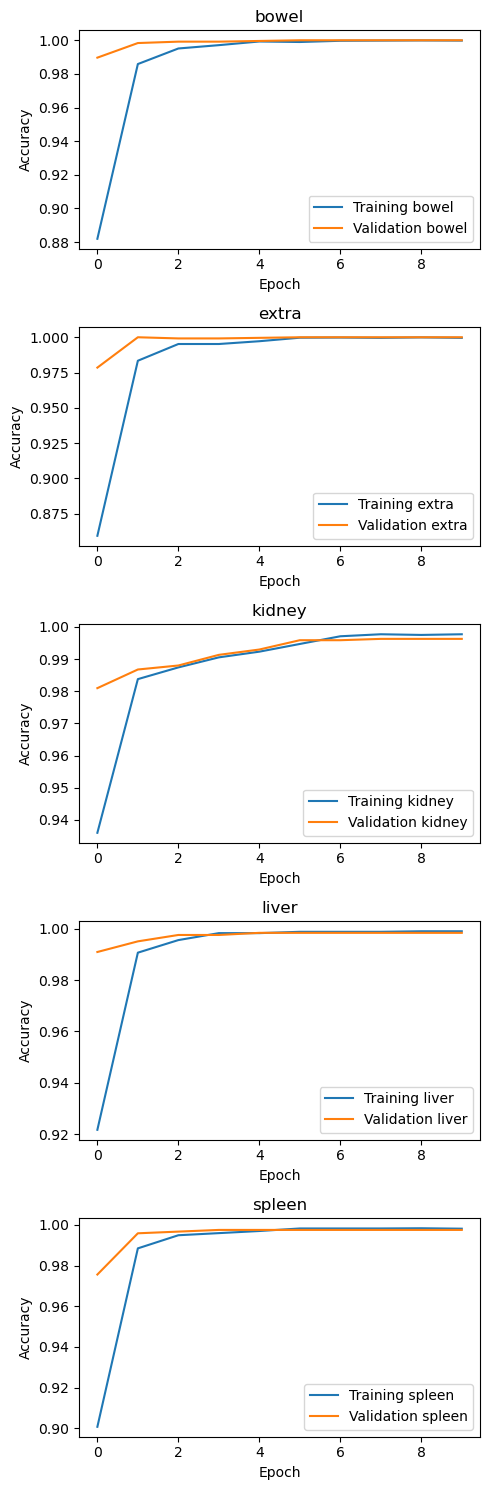

In [ ]:
# Create a 3x2 grid for the subplots
fig, axes = plt.subplots(5, 1, figsize=(5, 15))

# Flatten axes to iterate through them
axes = axes.flatten()

# Iterate through the metrics and plot them
for i, name in enumerate(["bowel", "extra", "kidney", "liver", "spleen"]):
    # Plot training accuracy
    axes[i].plot(logger.logged_metrics['train_' +name + '_accuracy'], label='Training ' + name)
    # Plot validation accuracy
    axes[i].plot(logger.logged_metrics['val_' + name + '_accuracy'], label='Validation ' + name)
    axes[i].set_title(name)
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Accuracy')
    axes[i].legend()

plt.tight_layout()
plt.show()


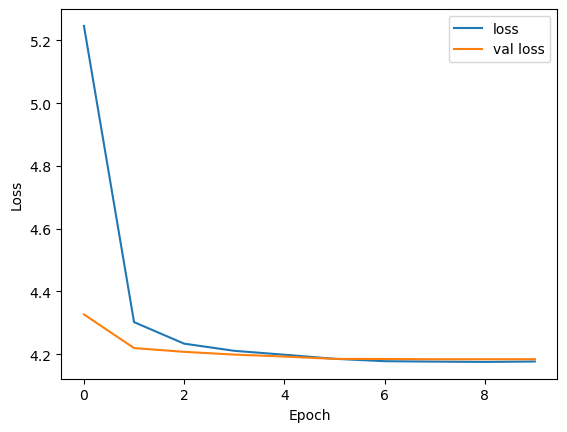

In [ ]:
plt.plot(logger.logged_metrics["train_loss_epoch"], label="loss")
plt.plot(logger.logged_metrics["val_loss"], label="val loss")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
# Find the best epoch based on validation loss
best_epoch = np.argmin(logger.logged_metrics['val_loss'])
best_loss = logger.logged_metrics['val_loss'][best_epoch]
best_acc_bowel = logger.logged_metrics[f'val_bowel_accuracy'][best_epoch]
best_acc_extra = logger.logged_metrics[f'val_extra_accuracy'][best_epoch]
best_acc_liver = logger.logged_metrics[f'val_liver_accuracy'][best_epoch]
best_acc_kidney = logger.logged_metrics[f'val_kidney_accuracy'][best_epoch]
best_acc_spleen = logger.logged_metrics[f'val_spleen_accuracy'][best_epoch]

# Calculate mean accuracy
best_acc = np.mean([best_acc_bowel, best_acc_extra, best_acc_liver, best_acc_kidney, best_acc_spleen])

print(f'>>>> BEST Loss  : {best_loss:.3f}\n>>>> BEST Acc   : {best_acc:.3f}\n>>>> BEST Epoch : {best_epoch}\n')
print('ORGAN Acc:')
print(f'  >>>> {"Bowel".ljust(15)} : {best_acc_bowel:.3f}')
print(f'  >>>> {"Extravasation".ljust(15)} : {best_acc_extra:.3f}')
print(f'  >>>> {"Liver".ljust(15)} : {best_acc_liver:.3f}')
print(f'  >>>> {"Kidney".ljust(15)} : {best_acc_kidney:.3f}')
print(f'  >>>> {"Spleen".ljust(15)} : {best_acc_spleen:.3f}')


>>>> BEST Loss  : 4.184
>>>> BEST Acc   : 0.998
>>>> BEST Epoch : 8

ORGAN Acc:
  >>>> Bowel           : 1.000
  >>>> Extravasation   : 1.000
  >>>> Liver           : 0.998
  >>>> Kidney          : 0.996
  >>>> Spleen          : 0.998


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=False)

In [ ]:
images, labels = next(iter(train_loader))
image = images[0].unsqueeze(0)
outputs = model(image)
outputs, labels[0].shape

([tensor([[0.2507, 0.7493]], grad_fn=<SoftmaxBackward0>),
  tensor([[0.0202, 0.9798]], grad_fn=<SoftmaxBackward0>),
  tensor([[0.9953, 0.0022, 0.0026]], grad_fn=<SoftmaxBackward0>),
  tensor([[0.9885, 0.0070, 0.0045]], grad_fn=<SoftmaxBackward0>),
  tensor([[0.9689, 0.0161, 0.0150]], grad_fn=<SoftmaxBackward0>),
  tensor([[0.9952]], grad_fn=<RsubBackward1>)],
 torch.Size([14]))

## Store the model for inference

In [ ]:
# Save the PyTorch model
SAVE_PATH = "rsna-atd.pth"
trainer.save_checkpoint(SAVE_PATH)

# Inference

- Build an inference model that makes per person inference by averaging across predictions over each CT scan.

In [ ]:
test_dataframe = pd.read_csv(f"{BASE_PATH}/test.csv")
test_dataframe.head()

,image_path,patient_id,series_id,instance_number,width,height
0,/kaggle/input/rsna-2023-abdominal-trauma-detec...,63706,39279,30,512,512
1,/kaggle/input/rsna-2023-abdominal-trauma-detec...,50046,24574,30,512,512
2,/kaggle/input/rsna-2023-abdominal-trauma-detec...,48843,62825,30,512,512


In [ ]:
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = image.resize(config.IMAGE_SIZE, Image.BILINEAR)
    image = transforms.ToTensor()(image)
    return image

In [ ]:
# load model if not already loaded
if not "model" in locals():
    model = CT_Model.load_from_checkpoint(SAVE_PATH)

model.eval()

predictions = []
for patient in test_dataframe["patient_id"]:
    patient_path = f"{BASE_PATH}/test_images/{patient}"
    session_path = os.path.join(patient_path, os.listdir(patient_path)[0])
    image_path = os.path.join(session_path, os.listdir(session_path)[0])
    image = load_image(image_path)
    image = image.unsqueeze(0)

    prediction = model(image)
    prediction = [p.detach().numpy().tolist()[0] for p in prediction]
    prediction = [item for sublist in prediction for item in sublist]
    predictions.append([patient]+prediction)
    
predictions = pd.DataFrame(predictions, columns=["patient_id"] + config.TARGET_COLS)
predictions.to_csv("submission.csv", index=False)


In [ ]:
predictions.head()

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury
0,63706,1.000000,2.696629e-07,0.000014,0.999986,0.998949,0.000666,0.000385,0.085086,0.000493,0.914421,0.012616,0.000081,0.987303,1.0
1,50046,0.999997,3.254200e-06,0.000039,0.999961,0.999175,0.000650,0.000175,0.038203,0.000434,0.961362,0.098836,0.000242,0.900922,1.0
2,48843,0.999863,1.373887e-04,0.000011,0.999989,0.998789,0.000987,0.000224,0.000029,0.003439,0.996532,0.999533,0.000031,0.000436,1.0


# Credits

This notebook was forked from https://www.kaggle.com/code/aritrag/kerascv-starter-notebook-train